# Simple example: Transformations from SQL to parametrized circuit

## Parsing

We parse the queries with ANTRL framework which is an extensive general-purpose parsing tool. We selected the SQLite grammar for its simplicity in ANTRL prewritten grammars. Because the core features of SQL are the same for any relational database, this code does not depend on system's SQL dialect.

So far, the module can deal with queries that have a SELECT-FROM-WHERE structure without substatements.

In [28]:
from antlr4 import *
from SQLiteLexer import SQLiteLexer
from SQLiteParser import SQLiteParser
from SQLiteParserListener import SQLiteParserListener
import json
import os
import glob
import random
from pathlib import Path
from discopy.grammar.pregroup import Box, Ty, Id, Word, Cup, Diagram, Functor, Swap
#from discopy.rigid import Diagram, Cup, Cap, Id, Ty, Box, Ob, Functor
from discopy import hypergraph
from functools import reduce
import numpy as np
import sympy
from discopy.quantum.pennylane import to_pennylane, PennyLaneCircuit
from sympy import default_sort_key
import pennylane as qml
import torch
from lambeq import IQPAnsatz
from flipped_IQPansatz import IQPAnsatzFlipped
from pennylane.drawer import draw,draw_mpl,tape_mpl
from discopy.utils import dumps, loads

#input_path = "/home/farida/Documents/SQL2Circuits_Farida/data/"

#input_file = 'cat.sql'
#input_file = '1join.sql'
#input_file = '2joins.sql'
#input_file = '3joins.sql'
#input_file = '4joins.sql'
#input_file = 'test_query1.sql'

input_path = "/home/farida/Documents/SQL2Circuits_Farida/data/training_set/"
input_file = 'q_1.sql'

input_stream = FileStream(input_path+input_file)
lexer = SQLiteLexer(input_stream)
stream = CommonTokenStream(lexer)
parser = SQLiteParser(stream)
tree = parser.parse()

print("Whole parse tree: ")
print(tree.toStringTree(recog=parser))

Whole parse tree: 
(parse (sql_stmt_list (sql_stmt (select_stmt (select_core SELECT (result_column (expr (table_name (any_name results)) . (column_name (any_name resultid)))) , (result_column (expr (table_name (any_name results)) . (column_name (any_name raceid)))) FROM (table_or_subquery (table_name (any_name results))) , (table_or_subquery (table_name (any_name status))) WHERE (expr (expr (table_name (any_name results)) . (column_name (any_name statusid))) = (expr (table_name (any_name status)) . (column_name (any_name statusid))))))) ;) <EOF>)


## Diagrammatic representation of SQL language elements in context free grammar

We walk the tree and collect the elements in a monoidal category. This creates a diagrammatic representation for the parsed SQL query. `SQLiteParserListener` class implements DisCoPy construction. First we collect the abstract parse tree but we also modify it so that we collect SELECT and the columns into the same element, FROM and tables into the same element and WHERE and the filtering clauses into the same element. This interpretation follows the [railroad diagram representation](https://www.sqlite.org/syntaxdiagrams.html#select-core) more accurately than the current parsing. It also enables us to map the parse tree correctly later.

In [29]:
this_folder = os.path.abspath(os.getcwd())
total_dim = 0
walker = ParseTreeWalker()
listener = SQLiteParserListener(parser)
walker.walk(listener, tree)
diagram = listener.get_final_diagram()
width = diagram.width
height = diagram.depth()
dim = 4*max(width, height)
total_dim += dim

In [30]:
#this_folder = '/home/farida/Documents/SQL2Circuits_Farida/diagrams/'

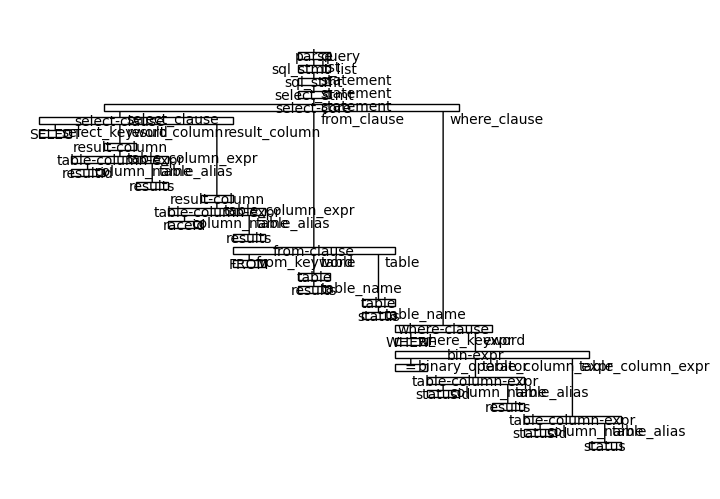

In [31]:
diagram.draw()

In [32]:
# figsize=(30, 20), fontsize = 17, fontsize_types = 17, scale = (0.8, 1),
#diagram.draw(path = this_folder + "CFG_diagram_1join.tex", to_tikz = True)

## Map context free grammar representations to pregroup representations

Because the abstract syntax tree contains lots of unnecessary information for our purposes, we will functorially rewrite it. This functorial rewriting process is just something that we have developed especially for this work and it is open to discussion if there exists a more suitable rewrite mapping. Also, the parts `select_main`, `from_main` and `where_main` are especially designed for this work although they are visible in the SQLite railroad diagrams without any special name.

Functor simply describes how the boxes and types are mapped. In this rewriting process we want to simplify the abstract syntax tree.

In [33]:
#from cfg_alias_rewriting_mappings import alias_object_mapping, alias_morphism_mapping

#Rewriter = Functor(ob = lambda x: alias_object_mapping(x), ar = lambda f: alias_morphism_mapping(f))
#cfg_diagram = Rewriter(diagram)
#cfg_diagram.draw(figsize=(15, 15)) #, path = this_folder + "\\figures\\pregroup_figure.png")

#back_n_forth = lambda f: hypergraph.Diagram.upgrade(f).downgrade()
#back_n_forth(cfg_diagram).draw(figsize=(15, 15))

In [34]:
from pregroupFunctorMappings import count_boxes, object_mapping, arrow_mapping

num_of_result_columns = count_boxes(diagram, "result-column")
num_of_result_columns += count_boxes(diagram, "result-column-with-alias")
num_of_tables = count_boxes(diagram, "table")
num_of_tables += count_boxes(diagram, "table-with-alias")

Rewriter = Functor(ob = lambda x: object_mapping(x, num_of_result_columns, num_of_tables), ar = lambda f: arrow_mapping(f, num_of_result_columns, num_of_tables))
pregroup_diagram = Rewriter(diagram)
width = pregroup_diagram.width
#height = pregroup_diagram.depth()
#dim = 3*max(width, height)
#total_dim += dim

In [35]:
print(dim)
#pregroup_diagram.draw(figsize=(23, 22), fontsize = 17, fontsize_types = 17, scale = (0.5, 1), path = this_folder + "pregroup_diagram_cat_example.tex", to_tikz = True)

32


## Convert pregroup representations to circuits

Following the ideas of the paper A Quantum Natural Language Processing Approach to Musical Intelligence, we can reduce the number of qubits by rewriting the diagram and removing cups.

An assumption is that every box contains a connection to a cup. On the other hand, the SELECT-box does not need to be changed. Thus for every box (which is not a cup or the select box) we "raise the first leg on top of the box". This process creates snakes which the normalization process automatically removes. This rewriting process ensures that the cups are removed from the diagram and we can use less qubits.

In [36]:
def cup_remove_arrow_mapping(box):
    if box.name.lower() == 'select':
        return box
    elif not box.cod:
        domain = box.dom
        raised_leg = domain[0]
        new_domain = reduce(lambda x, y : x @ y, domain[1:], Ty())
        new_box = Id(raised_leg) @ Box(box.name, new_domain, raised_leg.l) >> Cup(raised_leg, raised_leg.l)
        return new_box
    return box

def cup_remove_arrow_mapping2(box):
    if box.cod == box.dom == Ty('n'):
        return Id(box.cod)
    return box

cup_removal_functor = Functor(ob = lambda x: x, ar = lambda f: cup_remove_arrow_mapping(f))
cup_removal_functor2 = Functor(ob = lambda x: x, ar = lambda f: cup_remove_arrow_mapping2(f))

In [37]:
cupless_pregroup_diagram = cup_removal_functor(pregroup_diagram.normal_form()).normal_form()
cupless_pregroup_diagram = cup_removal_functor2(cupless_pregroup_diagram).normal_form()
width = cupless_pregroup_diagram.width
#height = cupless_pregroup_diagram.depth()
dim = 3*max(width, height)
total_dim += dim

In [38]:
#print(dim)
#cupless_pregroup_diagram.draw(figsize=(dim, dim), fontsize = 17, fontsize_types = 17, scale = (1,1), path = this_folder + "cup_removed_pregroup_diagram_2joins_example.tex", to_tikz = True)

In [39]:
#cup_removed_pregroup_folder_name = "join-order-benchmark-diagrams//cup-removed-pregroup-diagrams"
with open(this_folder + "4b" + ".json", 'w') as outfile:
    json.dump(json.loads(dumps(cupless_pregroup_diagram)), outfile)

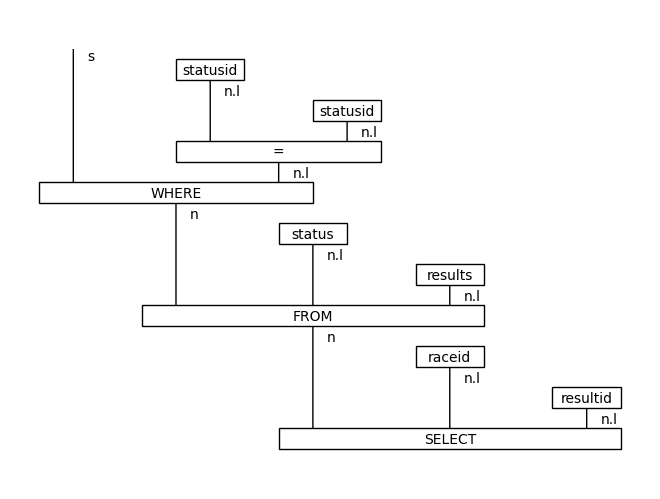

In [40]:
cupless_pregroup_diagram.draw()

### Pregroup grammar to circuit ansatz functor

In [41]:
n, s = Ty('n'), Ty('s')
ansatz = IQPAnsatzFlipped({n: 1, s: 1}, n_layers=1, n_single_qubit_params=1)
circuit_diagram = ansatz(cupless_pregroup_diagram)
width = circuit_diagram.width
height = circuit_diagram.depth()
dim = 0.9*max(width, height)
total_dim += dim

In [42]:
print(dim)
circuit_diagram.draw(figsize=(15, 20), fontsize = 17, fontsize_types = 17, scale = (0.6,0.7), path = this_folder + "circuit_diagram_4joins_example.png")

11.700000000000001


In [43]:
print(dim)
circuit_diagram.draw(figsize=(15, 20), fontsize = 17, fontsize_types = 17, scale = (0.6,0.7), path = this_folder + "circuit_diagram_1join_example.png")

11.700000000000001


In [44]:
for c in circuit_diagram:
    print(c)

qubit @ Ket(0)
qubit @ Rx(statusid__n.l_0)
qubit @ qubit @ Ket(0)
qubit @ qubit @ Rx(statusid__n.l_0)
qubit @ Rx(=_n.l@n.l_n.l_0) @ qubit
qubit @ qubit @ Rx(=_n.l@n.l_n.l_1)
qubit @ CRz(=_n.l@n.l_n.l_0)
qubit @ H @ qubit
qubit @ qubit @ H
qubit @ qubit @ Bra(0)
Rx(WHERE_s@n.l_n_0) @ qubit
qubit @ Rx(WHERE_s@n.l_n_1)
CRz(WHERE_s@n.l_n_0)
H @ qubit
qubit @ H
qubit @ Bra(0)
qubit @ Ket(0)
qubit @ Rx(status__n.l_0)
qubit @ qubit @ Ket(0)
qubit @ qubit @ Rx(results__n.l_0)
CRz(FROM_n@n.l@n.l_n_0) @ qubit
qubit @ CRz(FROM_n@n.l@n.l_n_1)
H @ qubit @ qubit
qubit @ H @ qubit
qubit @ qubit @ H
qubit @ Bra(0, 0)
qubit @ Ket(0)
qubit @ Rx(raceid__n.l_0)
qubit @ qubit @ Ket(0)
qubit @ qubit @ Rx(resultid__n.l_0)
CRz(SELECT_n@n.l@n.l__0) @ qubit
qubit @ CRz(SELECT_n@n.l@n.l__1)
H @ qubit @ qubit
qubit @ H @ qubit
qubit @ qubit @ H
Bra(0, 0, 0)


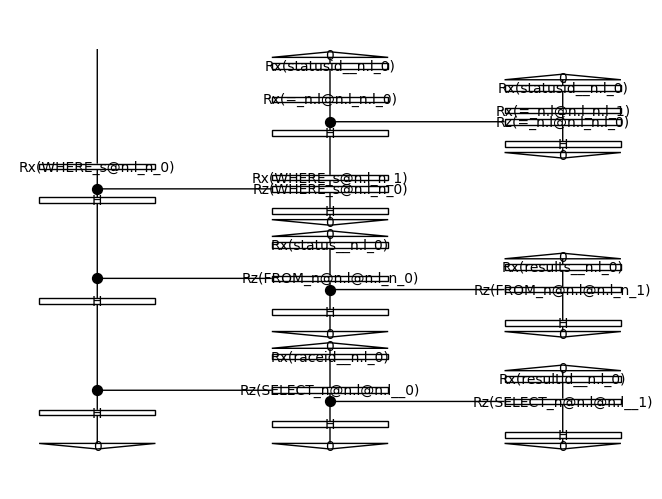

In [45]:
circuit_diagram.draw()

## Draw process in single figure

In [46]:
from discopy.drawing.legacy import Equation

equation_diagram = Equation(diagram, 
                            cupless_pregroup_diagram, 
                            circuit_diagram, 
                            symbol = '→').draw(
                            fontsize = 12,
                            figsize=(23, 9),
                            fontsize_types = 12, 
                            path = this_folder + "4joins_equation.png",
                            scale = (1.2, 0.7),
                            pad = (0,0),
                            draw_type_labels = False)

## Transforming circuit in Pennylane

In [47]:
#symbols = set([elem for c in all_circuits for elem in all_circuits[c].free_symbols])
symbols = list(sorted(circuit_diagram.free_symbols, key=default_sort_key))

pennylane_circuit = to_pennylane(circuit_diagram)
params = pennylane_circuit._params
#print(params)

ops = pennylane_circuit._ops
param_symbols = [[sym[0].as_ordered_factors()[0]] if len(sym) > 0 else [] for sym in params]
pennylane_wires = pennylane_circuit._wires

#circuit_elements = reversed(list(zip(ops, param_symbols, pennylane_wires)))
circuit_elements = list(zip(ops, param_symbols, pennylane_wires))
circuit_elements.reverse()
#print(circuit_elements)

symbol_to_index = {}
symbols = [str(x) for x in symbols]
for sym in param_symbols:
    if len(sym) > 0:
        symbol_to_index[sym[0]] = symbols.index(str(sym[0]))

In [48]:
len(symbols)

13

In [49]:
#dev = qml.device("qiskit.aer", wires=pennylane_circuit._n_qubits, backend='unitary_simulator')
dev = qml.device("qiskit.aer", wires=pennylane_circuit._n_qubits)
#dev = qml.device("default.qubit", wires = pennylane_circuit._n_qubits, shots = 10)
print('this circuit contains ', pennylane_circuit._n_qubits , " qubits")

@qml.qnode(dev)
def qml_circuit(circ_params):
    for op, param, wires in circuit_elements:
        if len(param) > 0:
            param = param[0]
            op(circ_params[symbol_to_index[param]], wires = wires)
        else:
            op(wires = wires)
    return qml.sample()

params = [2*np.pi*random.uniform(0, 1) for i in range(len(symbols))]
qml_circuit(params)
#dev._circuit.draw(output="mpl")

this circuit contains  7  qubits


array([[0, 0, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 1]])

In [50]:
dev._circuit.depth()

13

In [51]:
def qml_circuit(circ_params):
    #qml.Hadamard(wires = 0)
    for op, param, wires in circuit_elements:
        if len(param) > 0:
            param = param[0]
            op(circ_params[symbol_to_index[param]], wires = wires)
        else:
            op(wires = wires)
        #print(op)
    return qml.sample()

#dev = qml.device("qiskit.aer", wires=pennylane_circuit._n_qubits)
dev = qml.device("default.qubit", wires=pennylane_circuit._n_qubits, shots = 10)
qnode = qml.QNode(qml_circuit, dev)
params = [2*np.pi*random.uniform(0, 1) for i in range(len(symbols))]

In [52]:
circuit_elements

[(pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [2]),
 (pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [1]),
 (pennylane.ops.qubit.parametric_ops_controlled.CRZ,
  [SELECT_n@n.l@n.l__1],
  [1, 2]),
 (pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [0]),
 (pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [4]),
 (pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [3]),
 (pennylane.ops.qubit.parametric_ops_controlled.CRZ,
  [SELECT_n@n.l@n.l__0],
  [0, 1]),
 (pennylane.ops.qubit.parametric_ops_controlled.CRZ,
  [FROM_n@n.l@n.l_n_1],
  [3, 4]),
 (pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [0]),
 (pennylane.ops.qubit.parametric_ops_controlled.CRZ,
  [FROM_n@n.l@n.l_n_0],
  [0, 3]),
 (pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [5]),
 (pennylane.ops.qubit.non_parametric_ops.Hadamard, [], [0]),
 (pennylane.ops.qubit.parametric_ops_controlled.CRZ,
  [WHERE_s@n.l_n_0],
  [0, 5]),
 (pennylane.ops.qubit.parametric_ops_single_qubit.RX, [WHERE_s@n.l_n_1], 

In [53]:
results = qnode(params)
print(results)

[[0 1 0 1 1 1 1]
 [1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [1 1 0 0 1 1 1]
 [0 0 1 1 0 0 1]
 [0 0 0 1 1 0 1]
 [1 0 1 1 1 1 0]
 [1 1 0 1 1 1 1]
 [1 0 0 0 0 0 1]
 [1 0 1 1 1 0 1]]


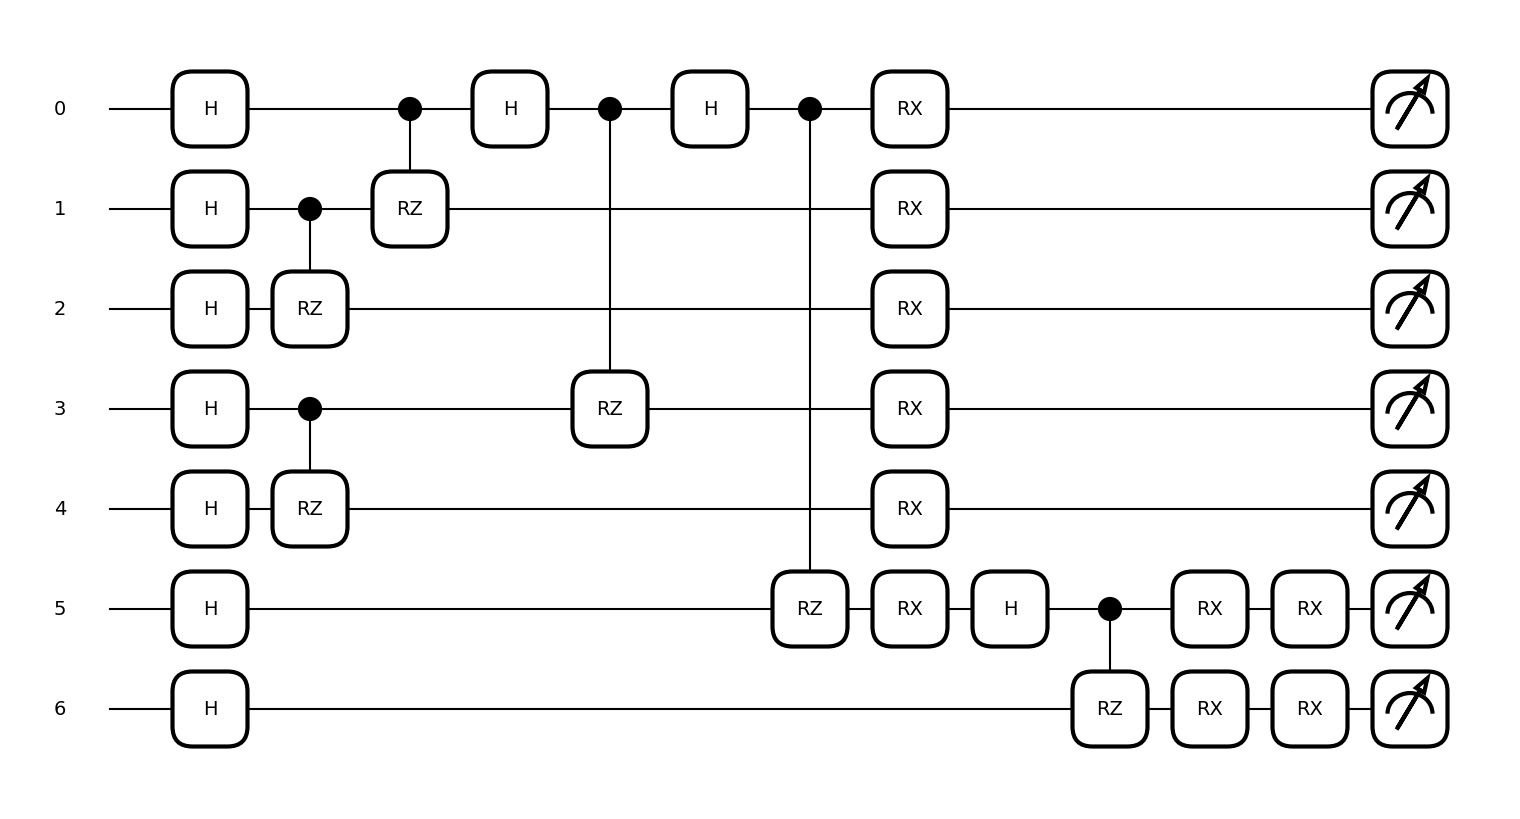

In [54]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode)(params)
plt.show()